# A* search demo

- <u>Author</u>: Zhihan Yang @ Carleton College
- <u>Date</u>: Tuesday, March 24, 2020

This notebook applies the A* search algorithm on a simple 2D maze. I used this notebook to learn about this algorithm for developing a playability tool for the PCGML GMM-VAE project, but it turned out to be unhelpful but valuable in its own right.

To learn more about the A* search algorithm, here's an excellent resource: http://csis.pace.edu/~benjamin/teaching/cs627/webfiles/Astar.pdf

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load maze

You can edit `maze.csv` using excel. If you happen to use Mac OS, you can first edit `maze.numbers` and then overwrite `maze.csv`. The advantage of the second approach is that `maze.numbers` uses conditional coloring depending the value in each box.

In [10]:
df = pd.read_csv('maze.csv')
df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,3.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
5,5.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
6,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
7,7.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
8,8.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
9,9.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0


In [4]:
# define slice instances for readability
without_nan_rows = np.s_[:10]
without_index_col = np.s_[:,1:]

In [5]:
maze_arr = np.array(pd.read_csv('maze.csv'))[without_nan_rows][without_index_col]

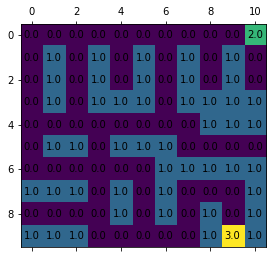

In [6]:
plt.matshow(maze_arr)
for (i, j), z in np.ndenumerate(maze_arr):
    plt.gca().text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

## Define MazeSolver class

In [8]:
class MazeSolver:
    
    """
    A simple maze solver using the A* search algorithm.
    Author: Zhihan Yang
    Date: Monday, March 23, 2020
    
    === The A* search algorithm ===
    - Add the starting node to the open list.
    - Repeat:
        
        - Look for the lowest F cost node on the open list. Refer to this as the current node.
        
        - Switch it to the closed list (remember to remove it from the open list).
        
        - For each of the 8 squares adjacent to this current node
            
            - If it is not walkable or if it is on the closed list, ignore it. Otherwise do:
                
                - If it isn't on the open list, add it to the open list. Make the crruent square
                  the parent of this square. Record F, G, and H costs of this node.
                
                - If it is on the open list already, check to see if this path to that node is better,
                  using G cost as the measure. A lower G cost measn a better path. If so, change the
                  parent of the node to the current node, and recalculate the G and F scores of
                  the node. Resort F scores (in case you keep your F scores sorted.)
                  
    - Stop when:
        - The target node is just added to the closest list, or
        - Fail to find the target square, and the open list is empty (no path).
        
    - Work backward and save the path.
    
    === References ===
    - A* Pathfinding for Beginners
        - Author: Patrick Lester
        - Link: http://csis.pace.edu/~benjamin/teaching/cs627/webfiles/Astar.pdf
    
    """
    
    def __init__(self, maze_arr):
        
        self.maze_arr = maze_arr
        self.state = 'unsolved'
        
        self.begin_row, self.begin_col = self.get_begin_pos(self.maze_arr)  # maze_arr[begin_row, begin_col] = 2
        self.end_row, self.end_col = self.get_end_pos(self.maze_arr)  # maze_arr[end_row, end_col] = 3
    
        # ======================================================================
        # G(n) is the cost of the path from the start node to n
        # - store a G value for each node
        # - not initialized before solving; values change during solving
        self.g_matrix = np.zeros((self.maze_arr.shape))  
        # ======================================================================
        
        # ======================================================================
        # H(n) is the estimated cost of the path from n to the end node
        # - store a H value for each node
        # - computed before solving starts; values do not change during solving        
        self.h_matrix = self.get_heuristic_matrix()  
        # ======================================================================
        
        # ======================================================================
        # F(n) is the estimated total cost of the path from the start node to the end node
        # - F_ij = G_ij + H_ij
        self.f_matrix = np.zeros((self.maze_arr.shape))
        # ======================================================================
        
        # ======================================================================
        # P(n) stores the parent of n
        self.p_matrix = np.zeros((self.maze_arr.shape), dtype=tuple)
        # ======================================================================
        
        self.open = []
        self.closed = []
        
    def get_begin_pos(self, maze_arr:np.array)->tuple:
        """
        Helper method to self.__init__(self, maze_arr).
        """
        row, col = np.where(maze_arr == 2) 
        return int(row), int(col)
    
    def get_end_pos(self, maze_arr:np.array)->tuple:
        """
        Helper method to self.__init__(self, maze_arr).
        """
        row, col = np.where(maze_arr == 3) 
        return int(row), int(col)
        
    @staticmethod
    def mahattan_distance(start:tuple, end:tuple)->int:
        """
        Compute the Mahattan distance between two tuples.
        Helper method to self.get_heuristic_matrix().
        """
        horizontal_distance = np.abs(end[0] - start[0])
        vertical_distance = np.abs(end[1] - start[1])
        return int(horizontal_distance + vertical_distance)

    def get_heuristic_matrix(self):
        """
        Computes the Mahatten distance between each node and the end node.
        Helper method to self.__init__(maze_arr).
        """
        
        heuristic_matrix = np.zeros(self.maze_arr.shape)
        
        for i in range(self.maze_arr.shape[0]):
            for j in range(self.maze_arr.shape[1]):
                heuristic_matrix[i][j] = self.mahattan_distance(
                    start=(i, j), 
                    end=(self.end_row, self.end_col)
                )
        
        return heuristic_matrix
    
    def is_walkable(self, row_idx:int, col_idx:int)->bool:
        """
        Determine whether a node is walkable.
        Helper method to self.get_neighbors(row_idx, col_idx).
        """
        if self.maze_arr[row_idx, col_idx] == 1.0: return False
        else: return True
        
    def get_neighbors(self, row_idx:int, col_idx:int)->list:
        """
        Return all the walkable neighbors of a node.
        Helper method to self.solve().
        """
        
        row_idxs = []
        
        if row_idx == 0:
            row_idxs.extend([row_idx, row_idx+1])
        
        elif row_idx == self.maze_arr.shape[0] - 1:
            row_idxs.extend([row_idx-1, row_idx])
        
        else:
            row_idxs.extend([row_idx-1, row_idx, row_idx+1])
        
        col_idxs = []
        
        if col_idx == 0:
            col_idxs.extend([col_idx, col_idx+1])
        
        elif col_idx == self.maze_arr.shape[1] - 1:
            col_idxs.extend([col_idx-1, col_idx])
        
        else:
            col_idxs.extend([col_idx-1, col_idx, col_idx+1])
            
        neighbors = []
        for i, ri in enumerate(row_idxs):
            for j, ci in enumerate(col_idxs):

                if (not (ri == row_idx and ci == col_idx)) and\
                    (ri == row_idx or ci == col_idx) and\
                    self.is_walkable(ri, ci):
                    neighbors.append((ri, ci))
                    
        return neighbors
    
    def get_f_score_for_pos(self, row_idx:int, col_idx:int)->float:
        """
        Function name is self-explanatory.
        Helper method to self.get_square_with_lowest_f_score_on_open_list().
        """
        return float(self.g_matrix[row_idx, col_idx] + self.h_matrix[row_idx, col_idx])
    
    def get_square_with_lowest_f_score_on_open_list(self)->tuple:
        """
        Function name is self-explanatory.
        Helper method to self.solve().
        """
        lowest_f = np.inf
        argmin_f = None
        for square in self.open:
            current_f_score = self.get_f_score_for_pos(*square)
            if current_f_score < lowest_f:
                lowest_f = current_f_score
                argmin_f = square
            elif np.allclose(current_f_score, lowest_f):
                p = np.random.uniform(0, 1)
                if p < 0.5:
                    lowest_f = current_f_score
                    argmin_f = square
        return square
    
    def solve(self)->None:
        """
        Call this function to solve the matrix.
        See the A* search algorithm available in the class header.
        """
        self.open.append((self.begin_row, self.begin_col))
        counter = 0
        last_current_square = None  # for debugging
        while True:
            
            if (self.end_row, self.end_col) in self.closed:
                self.state = 'solved'
                print('[Message from ms.solve()] Your maze was solved.')
                break
            elif len(self.open) == 0:
                self.state = 'unsolvable'
                print('[Message from ms.solve()] You maze is unsolvable.')
                break
            
            current_square = self.get_square_with_lowest_f_score_on_open_list()
                
            self.closed.append(current_square)
            self.open.remove(current_square)
            
            assert not current_square == last_current_square  # for debugging
            
            valid_neighbors = self.get_neighbors(*current_square)
            
            for n in valid_neighbors:
                if n not in self.closed:
                    if n not in self.open: 
                        self.open.append(n)
                        self.p_matrix[n] = current_square
                        self.g_matrix[n] = 1 + self.g_matrix[current_square]
                        self.f_matrix[n] = self.g_matrix[n] + self.h_matrix[n]
                    else:
                        potential_g = 1 + self.g_matrix[current_square]
                        if potential_g < self.g_matrix[n]:
                            self.g_matrix[n] = potential_g
                            self.f_matrix[n] = self.g_matrix[n] + self.h_matrix[n]
                        
            last_current_square = current_square  # for debugging
            
    def solution(self)->list:
        """
        List the nodes on the path discovered from the begin node to the end node.
        Helper function to self.plot(with_path=True).
        """
        path = []
        current_node = (self.end_row, self.end_col)
        path.append(current_node)
        while current_node != (self.begin_row, self.begin_col):
            current_node = self.p_matrix[current_node]
            path.append(current_node)
        return list(reversed(path))
    
    def plot(self, with_path:bool=True)->None:
        """
        Plot self.maze_arr using matplotlib.pyplot.matshow().
        """
        
        maze_array_copy = self.maze_arr.copy()  # avoid adding path directly to maze arr
        
        if self.state == 'unsolved':
            print('The maze is unsolved - path is not yet available.')
        elif self.state == 'solved':
            for node in self.solution():
                if node != (self.begin_row, self.begin_col) and node != (self.end_row, self.end_col):
                    maze_array_copy[node] = 4
        elif self.state == 'unsolvable':
            print('The maze is unsolvable - path is not available.')
        
        plt.matshow(maze_array_copy)
        plt.axis('off')
        plt.show()

[Message from ms.solve()] Your maze was solved.


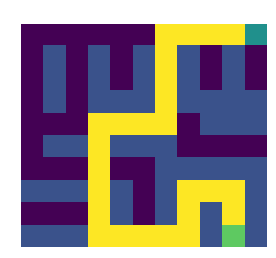

In [9]:
ms = MazeSolver(maze_arr)
ms.solve()
ms.plot()